# Lecture 2 — Modelling toolbox: ODEs and simulations

*2nd October 2025* - **Credits:** Luca Ciandrini (luca.ciandrini@umontpellier.fr)

**Goal of this notebook**
- Define a simple ODE: production–degradation model.
- Solve it **analytically**.
- Solve it **numerically** with a basic **Euler method**.
- Compare numerical vs analytical solutions and discuss step size.
- Use `scipy.integrate.solve_ivp` for solving ODEs.


Understand, formulate and analyse mathematical models based on ODEs, with basic analytical tools and numerically.

Today we are going to learn how to build up a simple model (for gene expression) with Ordinary Differential Equations (ODE). The tools that we will see can be exploited in many different contexts.


### Resources
- 3blue1brown on Differential equations, Chapter 1: https://www.3blue1brown.com/lessons/differential-equations 
- Strogatz, S. H. (2018). *Nonlinear Dynamics and Chaos: With Applications to Physics, Biology, Chemistry, and Engineering.* United States: CRC Press. The first chapter is available [here](https://www.google.fr/books/edition/Nonlinear_Dynamics_and_Chaos/1kpnDwAAQBAJ?hl=en&gbpv=1&printsec=frontcover).
- Stroagtz's lectures. [25 video-lectures](https://youtube.com/playlist?list=PLbN57C5Zdl6j_qJA-pARJnKsmROzPnO9V&si=r2DtHHlgo-6bNvD7) by Strogatz, who largely follows his book (see above).

## 1) The model

We study a simple production–degradation model:
\[
\frac{dX}{dt} = \alpha - \mu X,
\]
where:
- `alpha` is the constant production rate,
- `mu` is the degradation rate,
- `X(t)` is the amount (or concentration) of the species.

In [1]:
# Basic scientific Python imports
import numpy as np
import matplotlib.pyplot as plt

# No special styles or colors: we use defaults to keep things simple.
# Each figure will show a single plot.

In [4]:
# --- Parameters you can change ---
alpha = 1.0   # production rate
mu    = .01    # degradation rate
X0    = 0.0    # initial condition X(0)
t_end = 1000.0    # total time to simulate

print(f"alpha={alpha}, mu={mu}, X0={X0}, t_end={t_end}")

alpha=1.0, mu=0.01, X0=0.0, t_end=1000.0


In [5]:
def rhs(t, X, alpha, mu):
    """
    Right-hand side of the ODE dX/dt = alpha - mu*X.
    We include 't' for a standard function signature, even though
    the RHS here does not depend explicitly on time.
    """
    return alpha - mu*X

## 2) Analytical solution

For the ODE $$\frac{dX}{dt} = \alpha - \mu X$$ with $$X(0)=X_0$$,  
the analytical solution is:

$$
X(t) = \frac{\alpha}{\mu} + \big(X_0 - \frac{\alpha}{\mu}\big) e^{-\mu t}.
$$

We implement this formula and sample it on a regular time grid.

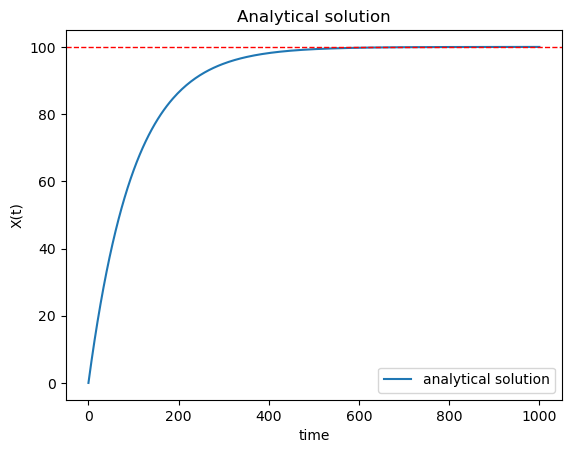

In [6]:
def X_analytic(t, alpha, mu, X0):
    """
    Analytical solution for dX/dt = alpha - mu*X with X(0)=X0.
    """
    steady = alpha / mu
    return steady + (X0 - steady) * np.exp(-mu * t)

# Build a time grid for plotting the analytical solution
t_analytic = np.linspace(0.0, t_end, 300)
X_ana = X_analytic(t_analytic, alpha, mu, X0)

# Quick plot: analytical only
plt.figure()
plt.plot(t_analytic, X_ana, label = 'analytical solution')  # default style
plt.axhline(alpha/mu, color='red', lw=1, linestyle='--')  # horizontal dashed line at y=steady state
plt.xlabel("time")
plt.ylabel("X(t)")
plt.title("Analytical solution")
plt.legend()
plt.show()

## 3) Numerical solution: explicit Euler method

We approximate the derivative by a finite difference:

$$
\frac{dX}{dt} \approx \frac{X_{i+1} - X_i}{\Delta t}
\quad \Rightarrow \quad 
X_{i+1} = X_i + \Delta t \cdot f(t_i, X_i).
$$

We implement a small Euler solver and compare the result with the analytical solution.

In [7]:
def euler_solve(rhs, t0, X0, dt, t_end, alpha, mu):
    """
    Explicit Euler integrator for dX/dt = rhs(t, X, alpha, mu).
    
    Returns:
      t: 1D array of times
      X: 1D array of solution values at those times
    """
    # Build a time grid with step dt (we ensure the end time is included)
    n_steps = int(np.ceil((t_end - t0) / dt))
    t = t0 + dt * np.arange(n_steps + 1)
    t[-1] = t_end  # force exact end time
    
    X = np.empty_like(t)
    X[0] = X0
    
    # Euler update: X_{i+1} = X_i + dt * f(t_i, X_i)
    for i in range(n_steps):
        f = rhs(t[i], X[i], alpha, mu)
        # If the last step is shorter than dt (due to rounding), adjust it:
        h = t[i+1] - t[i]
        X[i+1] = X[i] + h * f
    
    return t, X

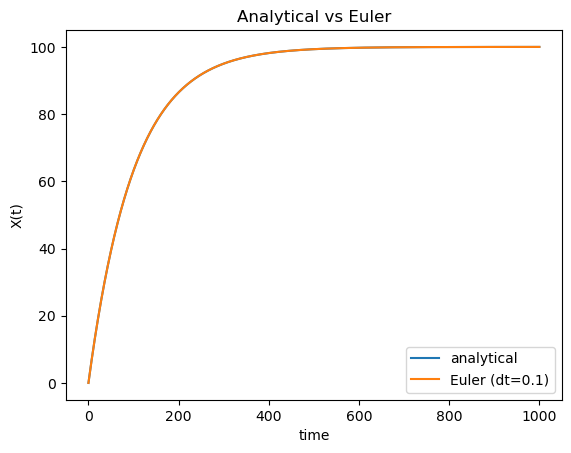

In [8]:
# Choose a "small enough" time step (you can change this)
dt = 0.1

# Numerical solution with Euler
t_num, X_num = euler_solve(rhs, t0=0.0, X0=X0, dt=dt, t_end=t_end, alpha=alpha, mu=mu)

# Analytical solution on the same time points (for a fair comparison)
X_ana_same_grid = X_analytic(t_num, alpha, mu, X0)

# Plot both on one figure
plt.figure()
plt.plot(t_num, X_ana_same_grid, label="analytical")   # default line
plt.plot(t_num, X_num, label=f"Euler (dt={dt})")       # default line
plt.xlabel("time")
plt.ylabel("X(t)")
plt.title("Analytical vs Euler")
plt.legend()
plt.show()

## 4) Step size matters

A smaller $\Delta t$ usually gives better accuracy, but costs more computation.
Let’s compare several values of $\Delta t$ against the analytical solution,  
and compute a simple error:

$$
\max_i \, |X_{\text{num}}(t_i) - X_{\text{ana}}(t_i)|.
$$

In [9]:
def max_abs_error(t, X_num, alpha, mu, X0):
    """
    Compute max absolute error between numerical and analytical solutions
    at the same time points t.
    """
    X_true = X_analytic(t, alpha, mu, X0)
    return np.max(np.abs(X_num - X_true))

dt_list = [0.5, 0.2, 0.1, 0.05, 0.02]
errors = []

for dt in dt_list:
    t_num, X_num = euler_solve(rhs, 0.0, X0, dt, t_end, alpha, mu)
    err = max_abs_error(t_num, X_num, alpha, mu, X0)
    errors.append((dt, err))

# Print a small table
print("dt\tmax |error|")
for dt, err in errors:
    print(f"{dt}\t{err:.6f}")

dt	max |error|
0.5	0.092162
0.2	0.036819
0.1	0.018402
0.05	0.009199
0.02	0.003679


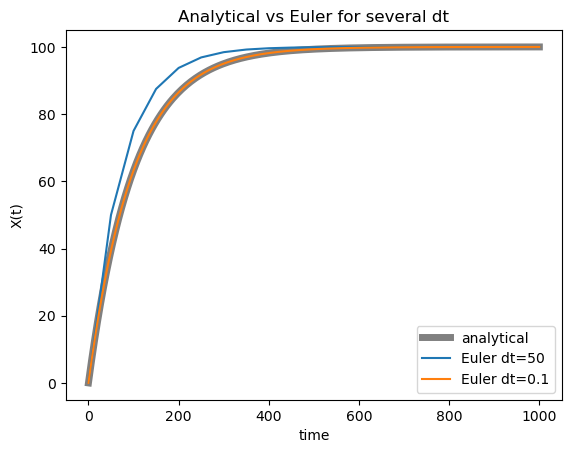

In [10]:
# Plot a few Euler solutions together with the analytical curve
plt.figure()
plt.plot(t_analytic, X_ana, label="analytical", lw=5, color='gray')  # default
for dt in [50, 0.1]:
    t_num, X_num = euler_solve(rhs, 0.0, X0, dt, t_end, alpha, mu)
    plt.plot(t_num, X_num, label=f"Euler dt={dt}")
plt.xlabel("time")
plt.ylabel("X(t)")
plt.title("Analytical vs Euler for several dt")
plt.legend()
plt.show()

## 5) (Optional) Stability intuition

For the production–degradation ODE, Euler is stable for a wide range of step sizes,  
but if $\Delta t$ is too large, the method can overshoot and oscillate.  
Try $\Delta t = 1.5$ or $\Delta t = 2.0$ below and see what happens.

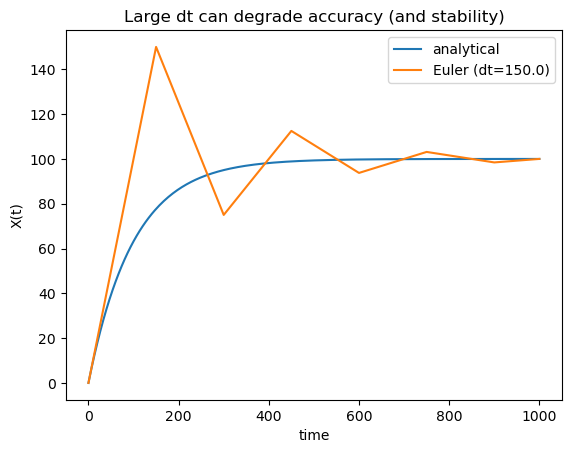

In [11]:
# Try a large time step to see poor behavior (if any)
dt_bad = 150.0
t_bad, X_bad = euler_solve(rhs, 0.0, X0, dt_bad, t_end, alpha, mu)

plt.figure()
plt.plot(t_analytic, X_ana, label="analytical")
plt.plot(t_bad, X_bad, label=f"Euler (dt={dt_bad})")
plt.xlabel("time")
plt.ylabel("X(t)")
plt.title("Large dt can degrade accuracy (and stability)")
plt.legend()
plt.show()

## 6) Summary

- We solved a simple ODE both **analytically** and **numerically** (Euler).
- We observed how the **step size** affects the accuracy.
- In practice we prefer higher-order methods (e.g. Runge–Kutta), but Euler is a good starting point to understand ideas.
- Next: extend to **stochastic simulations** (Gillespie) for the same process.

## Using `scipy.integrate.solve_ivp` for ODEs

We will use `solve_ivp` to integrate ODEs numerically.

**Core idea:** we define a Python function for the right-hand side (RHS) of the ODE:
- signature: `f(t, y, *params)`  
- returns the derivative(s) at time `t` for state vector `y`.

**Basic usage:**
```python
from scipy.integrate import solve_ivp

sol = solve_ivp(fun=f,              # RHS function f(t, y, ...)
                t_span=(t0, tf),    # start and end times
                y0=y0,              # initial state (array-like)
                t_eval=t_eval,      # times where we want the solution
                args=(...),         # extra parameters passed to f
                method='RK45',      # default explicit Runge–Kutta (order 5)
                rtol=1e-6, atol=1e-9)  # tolerances (accuracy controls)

In [12]:
from scipy.integrate import solve_ivp

### 1) Production–degradation ODE

Model:
$$
\frac{dX}{dt} = \alpha - \mu X, \qquad X(0)=X_0.
$$

We will:
1. Define the RHS function `f_pd(t, y, alpha, mu)`.
2. Call `solve_ivp` on a time grid.
3. Compare with the analytical solution.

In [13]:
# Parameters (you can change these)
alpha = 1.0   # production rate
mu    = 0.1    # degradation rate
X0    = 0.0    # initial condition
t0, tf = 0.0, 1000.0

def f_pd(t, y, alpha, mu):
    """
    RHS for production–degradation: dX/dt = alpha - mu*X
    y is a 1-element array-like: y[0] = X
    """
    X = y[0]
    dXdt = alpha - mu*X
    return [dXdt]

In [14]:
# Where we want the solution evaluated (uniform grid for plotting)
t_eval = np.linspace(t0, tf, 300)

# Integrate ODE with default RK45
sol_pd = solve_ivp(fun=f_pd,
                   t_span=(t0, tf),
                   y0=[X0],
                   t_eval=t_eval,
                   args=(alpha, mu),
                   method='RK45',
                   rtol=1e-8, atol=1e-10)

# Basic sanity check
print("Success:", sol_pd.success, "| message:", sol_pd.message)

Success: True | message: The solver successfully reached the end of the integration interval.


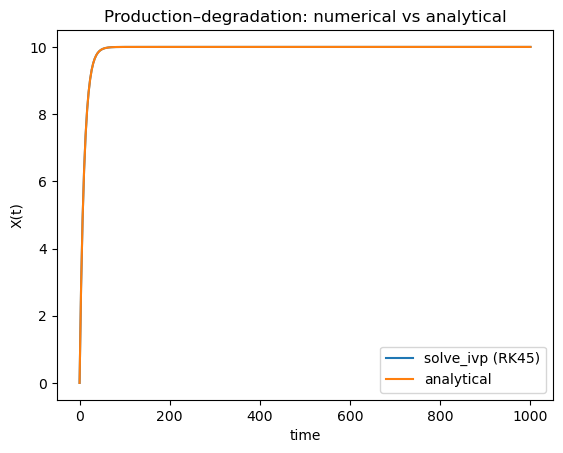

In [15]:
# Analytical solution on the same time points

X_ana = X_analytic(sol_pd.t, alpha, mu, X0)

plt.figure()
plt.plot(sol_pd.t, sol_pd.y[0], label="solve_ivp (RK45)")
plt.plot(sol_pd.t, X_ana, label="analytical")
plt.xlabel("time")
plt.ylabel("X(t)")
plt.title("Production–degradation: numerical vs analytical")
plt.legend()
plt.show()

**Accuracy controls:** `rtol` (relative tolerance) and `atol` (absolute tolerance).

- Smaller tolerances → higher accuracy (more steps, slower).
- Larger tolerances → lower accuracy (fewer steps, faster).

Try changing `rtol, atol` and see how the curve changes (it should match the analytical solution very closely for reasonable tolerances).

## Michaelis–Menten (QSSA)

Under the quasi–steady-state assumption (QSSA), the reaction rate is
$$
v(S) = \frac{V_{\max}\, S}{K_M + S}.
$$
A simple ODE model is:
$$
\frac{dS}{dt} = -v(S), \qquad \frac{dP}{dt} = v(S),
$$
with $S(0)=S_0$, $P(0)=0$. Here $V_{\max} = k_{\text{cat}} E_0$ and $K_M=(k_{-1}+k_{\text{cat}})/k_1$.

In [16]:
# Parameters for Michaelis–Menten (QSSA)
Vmax = 1.0    # max rate
Km   = 0.5    # Michaelis constant
S0   = 2.0    # initial substrate
P0   = 0.0    # initial product
t0, tf = 0.0, 10.0
t_eval = np.linspace(t0, tf, 400)

def f_mm_qssa(t, y, Vmax, Km):
    """
    y = [S, P]
    dS/dt = - Vmax * S / (Km + S)
    dP/dt =   Vmax * S / (Km + S)
    """
    S, P = y
    v = Vmax * S / (Km + S)
    dSdt = -v
    dPdt =  v
    return [dSdt, dPdt]

sol_mm_qssa = solve_ivp(fun=f_mm_qssa,
                        t_span=(t0, tf),
                        y0=[S0, P0],
                        t_eval=t_eval,
                        args=(Vmax, Km),
                        method='RK45',
                        rtol=1e-7, atol=1e-9)

print("MM QSSA success:", sol_mm_qssa.success)

MM QSSA success: True


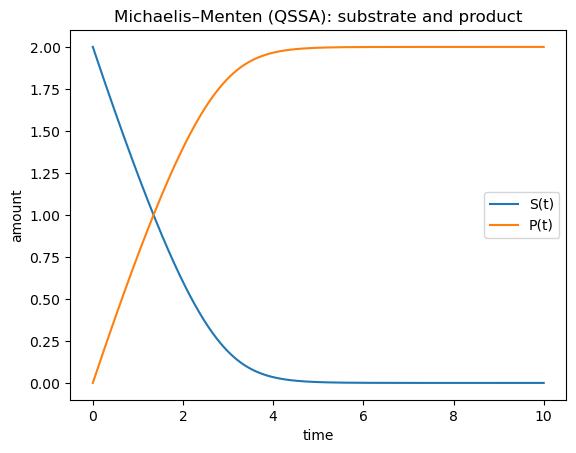

In [17]:
plt.figure()
plt.plot(sol_mm_qssa.t, sol_mm_qssa.y[0], label="S(t)")
plt.plot(sol_mm_qssa.t, sol_mm_qssa.y[1], label="P(t)")
plt.xlabel("time")
plt.ylabel("amount")
plt.title("Michaelis–Menten (QSSA): substrate and product")
plt.legend()
plt.show()

## (Optional) Full mass-action Michaelis–Menten

Mechanism:
$$
E + S \ \underset{k_{-1}}{\stackrel{k_1}{\rightleftharpoons}} \ ES \ \xrightarrow{k_{\text{cat}}}\ E + P.
$$

ODEs:
$$
\begin{aligned}
\frac{dS}{dt}   &= -k_1 E S + k_{-1} ES,\\
\frac{dE}{dt}   &= -k_1 E S + (k_{-1} + k_{\text{cat}}) ES,\\
\frac{dES}{dt}  &= k_1 E S - (k_{-1} + k_{\text{cat}}) ES,\\
\frac{dP}{dt}   &= k_{\text{cat}} ES,
\end{aligned}
$$
with conservation $E_{\text{tot}} = E + ES$ if you prefer to eliminate one variable.

In [18]:
# Kinetic parameters (you can tweak)
k1     = 10.0     # binding rate (E + S -> ES)
k_1    = 5.0      # unbinding rate (ES -> E + S)
kcat   = 1.0      # catalytic rate (ES -> E + P)

# Initial conditions
S0   = 2.0
E0   = 0.5
ES0  = 0.0
P0   = 0.0
y0   = [S0, E0, ES0, P0]

t0, tf = 0.0, 2.0
t_eval = np.linspace(t0, tf, 400)

def f_mm_full(t, y, k1, k_1, kcat):
    """
    Full mass-action MM:
    y = [S, E, ES, P]
    """
    S, E, ES, P = y
    dS  = -k1*E*S + k_1*ES
    dE  = -k1*E*S + (k_1 + kcat)*ES
    dES =  k1*E*S - (k_1 + kcat)*ES
    dP  =  kcat*ES
    return [dS, dE, dES, dP]

sol_mm_full = solve_ivp(fun=f_mm_full,
                        t_span=(t0, tf),
                        y0=y0,
                        t_eval=t_eval,
                        args=(k1, k_1, kcat),
                        method='RK45',
                        rtol=1e-7, atol=1e-9)

print("MM full success:", sol_mm_full.success)

MM full success: True


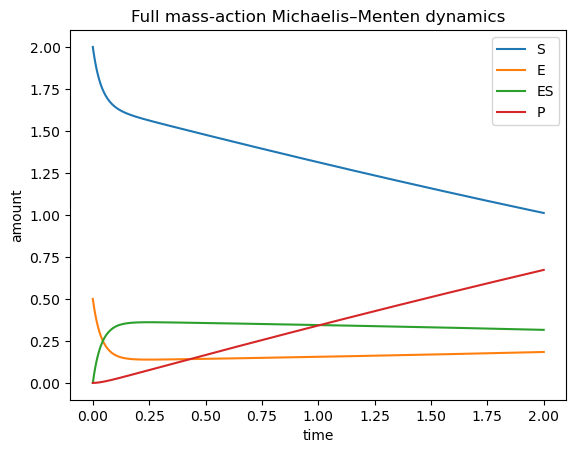

In [19]:
S, E, ES, P = sol_mm_full.y

plt.figure()
plt.plot(sol_mm_full.t, S,  label="S")
plt.plot(sol_mm_full.t, E,  label="E")
plt.plot(sol_mm_full.t, ES, label="ES")
plt.plot(sol_mm_full.t, P,  label="P")
plt.xlabel("time")
plt.ylabel("amount")
plt.title("Full mass-action Michaelis–Menten dynamics")
plt.legend()
plt.show()